# _Stjórn_ Stylometry

| Work         | Date             | Material      | Incipit                                                                         |
| ------------ | ---------------- | ------------- | ------------------------------------------------------------------------------- |
| _Stjórn I_   | s. xiv in.       | Gn--Ex 18.27  | i upphafi skapadi gud himin þat er sealft himinriki                             |
| _Stjórn II_  | s. xiii in.      | Ex 19--Dt     | a þridia manadi eptir brottfaur gydinga af egiptalandi komu þeir i audn synay   |
| _Stjórn III_ | s. xiii med.     | Ios           | moyses agietr guds uin aðr hann andadizt hafðe at guds raaðe                    |
| _Stjórn IV_  | ?                | Ios           | eptir andlat moyses ok harmsong þann er gydingar sungu eptir hann               |
| _Stjórn III_ | as above         | Idc--Rg       | efter andlat iosue læitaði israels lyðr raðs uið guð sua segiandi               |

Unger's edition relies primarily on [AM 226](https://handrit.is/manuscript/view/da/AM02-0226/0?iabr=on#mode/2up) (written 1360x1370) for _Stjórn I--II_ and _IV_ and [AM 227](https://handrit.is/manuscript/view/is/AM02-0227/0?iabr=on#mode/2up) (written ca. 1350) for _Stjórn III_. _Stjórn IV_ refers to a shorter redaction of the material from the Book of Joshua, drawn from Peter Comestor's _Historica Scholastica_ and contained in AM 226 (and copied thence into AM 225).

In [3]:
import os,glob,json,copy,statistics,time
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import pandas as pd
from bisect import bisect_left
from lexicalrichness import LexicalRichness
%matplotlib widget

def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left = lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)

def normalize(target):
    # This dict limits orthographical variation beyond the rule sets
    # of stjorn-extract.ipynb and menota-extract.ipynb:
    matrix = {
        'j': 'i',
        'v': 'u',
        # Use of d for ð in AM 226 rather spoils the results,
        # so instead of normalizing ð to þ we will normalize
        # both to d (resulting in strange forms of course):
        #'ð': 'þ',
        'ð': 'd',
        'þ': 'd',
        'á': 'a',
        'ǽ': 'æ',
        'é': 'e',
        'í': 'i',
        'ó': 'o',
        'ú': 'u',
        'ý': 'y',
        'ǿ': 'ø',
        'k': 'c', # rather than vice versa, because of Latin (e.g. Lucifer)
        '[': '',
        ']': ''
        }
    for k,v in matrix.items():
        target = target.replace(k, v)
    return target


In [4]:
chunk_size = 2000

In [5]:
with open('token_indices.json') as index_file:
    token_indices = json.load(index_file)

titles = ['prologue', 'introduction', 'gn', 'ex', 'lv', 'nm', 'dt', 'ios', 'idc', 'rt', '1sm', '2sm', '3rg', '4rg']
work_indices = {
    'stjorn1': 650,
    'stjorn2': 124417,
    'stjorn3a': 147678,
    'stjorn4': 156943,
    'stjorn3b': 160719
}

tokens = []
for title in titles:
    with open(f"nlp/{title}.txt") as raw:
        document = normalize(raw.read().replace('\n', ' '))
        tokens.extend(document.split())

In [6]:
text = dict()
section_list = list(token_indices.keys())
for index,section in enumerate(section_list):
    if section == section_list[-1]:
        text[section] = tokens[token_indices[section]:]
    else:
        next = section_list[index+1]
        text[section] = tokens[token_indices[section]:token_indices[next]]


In [7]:
reverse_index = {v: k for k, v in token_indices.items()}
def index_to_identifiers(needle, haystack=list(token_indices.values())):
    pos_start = bisect_left(haystack, needle)
    pos_end = bisect_left(haystack, needle+chunk_size)
    if pos_start == 0:
        start = reverse_index[haystack[0]]
        end = reverse_index[haystack[pos_end - 1]]
    else:
        start = reverse_index[haystack[pos_start - 1]]
        end = reverse_index[haystack[pos_end - 1]]
    # if BOTH are in the Prologue range (only happens with chunk sizes below 650 tokens):
    if needle+chunk_size < work_indices['stjorn1']:
        color = ('#C7472E', '#C7472E') # red
    # if BOTH are in the Stjórn I range:
    elif work_indices['stjorn1'] <= needle < work_indices['stjorn2'] and work_indices['stjorn1'] <= needle+chunk_size < work_indices['stjorn2']:
        color = ('#264FA6', '#264FA6') # dark blue
    # if BOTH are in the Stjórn II range:
    elif work_indices['stjorn2'] <= needle < work_indices['stjorn3a'] and work_indices['stjorn2'] <= needle < work_indices['stjorn3a'] and work_indices['stjorn2'] <= needle+chunk_size < work_indices['stjorn3a']:
        color = ('#C27A13', '#C27A13') # orange
    # if BOTH are in the Stjórn III range:
    elif needle >= work_indices['stjorn3b'] or (work_indices['stjorn3a'] <= needle < work_indices['stjorn4'] and work_indices['stjorn3a'] <= needle+chunk_size < work_indices['stjorn4']):
        color = ('#355E26', '#355E26') # green
    # if BOTH are in the Stjórn IV range:
    elif work_indices['stjorn4'] <= needle < work_indices['stjorn3b'] and work_indices['stjorn4'] <= needle+chunk_size < work_indices['stjorn3b']:
        color = ('#ABA75B', '#ABA75B') # cameo
    # if START is in the Prologue but END is in Stjórn I:
    elif needle <= work_indices['stjorn1'] and work_indices['stjorn1'] <= needle+chunk_size < work_indices['stjorn2']:
        color = ('#C7472E', '#264FA6') # red, dark blue
     # if START is in Stjórn I but END is in Stjórn II:
    elif work_indices['stjorn1'] <= needle < work_indices['stjorn2'] and work_indices['stjorn2'] <= needle+chunk_size < work_indices['stjorn3a']:
        color = ('#264FA6', '#C27A13') # dark blue, orange
    # if START is in Stjórn II but END is in Stjórn III:
    elif work_indices['stjorn2'] <= needle < work_indices['stjorn3a'] and work_indices['stjorn3a'] <= needle+chunk_size < work_indices['stjorn4']:
        color = ('#C27A13', '#355E26') # orange, green
    # if START is in Stjórn III but END is in Stjórn IV:
    elif work_indices['stjorn3a'] <= needle and work_indices['stjorn4'] <= needle+chunk_size < work_indices['stjorn3b']:
        color = ('#355E26', '#ABA75B') # green, cameo
    # if START is in Stjórn IV but END is in Stjórn III:
    elif work_indices['stjorn4'] <= needle and work_indices['stjorn3b'] <= needle+chunk_size:
        color = ('#ABA75B', '#355E26') # cameo, green
    # if START is in Stjórn I but END is in Stjórn III, so Stjórn II is included:
    elif work_indices['stjorn1'] <= needle and work_indices['stjorn3a'] <= needle+chunk_size:
        color = ('#264FA6', '#355E26') # dark blue, green
    # if START is in Stjórn IIIa but END is in Stjórn IIIb, so Stjórn IV is included:
    elif work_indices['stjorn3a'] <= needle and work_indices['stjorn3b'] <= needle+chunk_size:
        color = ('#355E26', '#ABA75B') # green, cameo

    if start == end:
        return (start, color)
    else:
        return (start + '–' + end, color)

In [8]:
test = index_to_identifiers(160000)
print(test)

('ios15-18(stj4)–idc2', ('#ABA75B', '#355E26'))


In [9]:
chunks = dict()
index_counter = 0
while index_counter < len(tokens):
    current_index = copy.copy(index_counter)
    if len(tokens)-current_index < chunk_size:
        chunk = tokens[current_index:]
    else:
        chunk = tokens[current_index:current_index+chunk_size]
        chunks[current_index] = (index_to_identifiers(current_index)[0], index_to_identifiers(current_index)[1], chunk)
    index_counter = current_index + chunk_size
current_index = len(tokens) - (len(tokens) % chunk_size) -1
remnant = tokens[current_index:]
chunks[current_index] = (index_to_identifiers(current_index)[0], index_to_identifiers(current_index)[1], remnant)

In [10]:
ld = list()

for chunk in chunks.values():
    lex = LexicalRichness(chunk[2], preprocessor=None, tokenizer=None)
    ld.append((chunk[0], chunk[1], lex.ttr))

In [11]:
print(ld)

[('prologue–introduction', ('#C7472E', '#264FA6'), 0.411), ('introduction–gn1', ('#264FA6', '#264FA6'), 0.4145), ('gn1', ('#264FA6', '#264FA6'), 0.381), ('gn1', ('#264FA6', '#264FA6'), 0.3975), ('gn1–gn2', ('#264FA6', '#264FA6'), 0.389), ('gn2', ('#264FA6', '#264FA6'), 0.4145), ('gn2–gn3', ('#264FA6', '#264FA6'), 0.369), ('gn3', ('#264FA6', '#264FA6'), 0.3715), ('gn3–gn4', ('#264FA6', '#264FA6'), 0.411), ('gn4', ('#264FA6', '#264FA6'), 0.3975), ('gn4–gn6', ('#264FA6', '#264FA6'), 0.428), ('gn6–gn7', ('#264FA6', '#264FA6'), 0.384), ('gn7–gn9', ('#264FA6', '#264FA6'), 0.384), ('gn9–af skipan heimsins', ('#264FA6', '#264FA6'), 0.4255), ('af skipan heimsins', ('#264FA6', '#264FA6'), 0.4295), ('af skipan heimsins–af egipta landi', ('#264FA6', '#264FA6'), 0.412), ('af egipta landi–af europa', ('#264FA6', '#264FA6'), 0.4525), ('af europa–flod', ('#264FA6', '#264FA6'), 0.3845), ('flod', ('#264FA6', '#264FA6'), 0.4345), ('flod–af affrica', ('#264FA6', '#264FA6'), 0.409), ('af affrica–belo', ('#

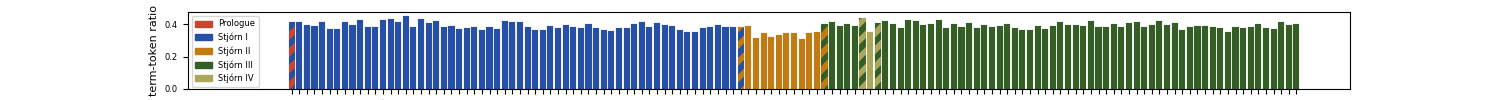

In [12]:
# This plot now needs adjusting to the %matplotlib widget backend.
# Title and chunk labels show in the output image,
# but presumably need some margin setting to be visible here.
fig, ax = plt.subplots(figsize=(15,1))
x = [p[0] for p in ld]
y = [p[2] for p in ld]
color = [p[1][0] for p in ld]
hatch_color =[p[1][1] for p in ld]
ax.bar(x,y, color=color, edgecolor=hatch_color, hatch="//", lw=.1, zorder = 0)
ax.set_ylabel('term-token ratio', fontsize='8')
ax.set_title('Term-Token Ratio for ' + str(chunk_size) + '-token chunks of Stjórn', fontsize='12', pad='20')
plt.xticks(rotation='vertical')
rcParams['hatch.linewidth'] = 4
legend_data = [
    mpatches.Patch(color='#C7472E', label='Prologue'), 
    mpatches.Patch(color='#264FA6', label='Stjórn I'), 
    mpatches.Patch(color='#C27A13', label='Stjórn II'), 
    mpatches.Patch(color='#355E26', label='Stjórn III'), 
    mpatches.Patch(color='#ABA75B', label='Stjórn IV')
    ]
plt.legend(handles=legend_data, loc='upper left', prop={'size': 6})
ax.tick_params(axis='both', which='major', labelsize=6)
#plt.subplots_adjust(wspace=0.8)
set_xmargin(ax, left=0.1, right=0.05)
plt.savefig(fname='ttr.svg', format='svg', bbox_inches='tight')
plt.show()


In [13]:
def ttravg(start, stop, chunksize=1000):
    data = []
    while (stop - start) >= chunksize:
        chunk = tokens[start:start+chunksize]
        lex = LexicalRichness(chunk, preprocessor=None, tokenizer=None)
        data.append(lex.ttr)
        start += chunksize
    return round(statistics.fmean(data), 2)

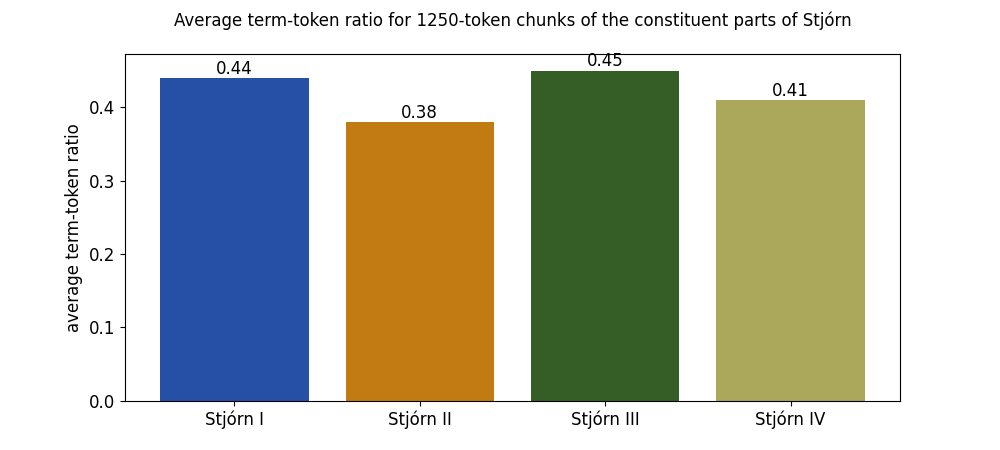

In [14]:
stj1_ttr = ttravg(work_indices['stjorn1'], work_indices['stjorn2'], 1250)
stj2_ttr = ttravg(work_indices['stjorn2'], work_indices['stjorn3a'], 1250)
stj3_ttr = round(statistics.fmean([ttravg(work_indices['stjorn3a'], work_indices['stjorn4'], 1250), ttravg(work_indices['stjorn3b'], len(tokens)-1, 1250)]), 2)
stj4_ttr = ttravg(work_indices['stjorn4'], work_indices['stjorn3b'], 1250)

fig, ax = plt.subplots(figsize=(10,4.5))
#This plot now needs adjusting to the %matplotlib widget backend.
x = ['Stjórn I', 'Stjórn II', 'Stjórn III', 'Stjórn IV']
y = [stj1_ttr, stj2_ttr, stj3_ttr, stj4_ttr]
color = ['#264FA6', '#C27A13', '#355E26', '#ABA75B']
ax.bar(x,y, color=color)
ax.set_ylabel('average term-token ratio', fontsize='12')
ax.set_title('Average term-token ratio for 1250-token chunks of the constituent parts of Stjórn', fontsize='12', pad='20')
plt.xticks()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.bar_label(ax.containers[0], label_type='edge', fontsize='12')
plt.savefig(fname='avg_ttr.svg', format='svg')
plt.show()


## Intersection and Difference

For our next exercise, we'll measure the number of terms _Stjórn_ has in common with other Old Norse works. Let's start with absolute intersection and difference. Note that it is important that the level of normalization between all these works be similar, so in the Menota routine elsewhere in this repository I have attempted to mimic Unger's standard.

It is also important to be aware of the length in tokens of the works under study. We'll take note of the length of constituent parts of _Stjórn_ here, and then we'll build in a length ratio for the works in Menota.

In [15]:
stjorn_tokens = dict()
stjorn_tokens['stj1'] = tokens[work_indices['stjorn1']:work_indices['stjorn2']]
stjorn_tokens['stj2'] = tokens[work_indices['stjorn2']:work_indices['stjorn3a']]
stjorn_tokens['stj3'] = tokens[work_indices['stjorn3a']:work_indices['stjorn4']] + tokens[work_indices['stjorn3b']:]
stjorn_tokens['stj4'] = tokens[work_indices['stjorn4']:work_indices['stjorn3b']]

stjorn_length = []
stjorn_length.append(('Stjórn I', len(stjorn_tokens['stj1'])))
stjorn_length.append(('Stjórn II', len(stjorn_tokens['stj2'])))
stjorn_length.append(('Stjórn III', len(stjorn_tokens['stj3'])))
stjorn_length.append(('Stjórn IV', len(stjorn_tokens['stj4'])))

df = pd.DataFrame(stjorn_length, columns=['work', 'length'])
df['length'] = df['length'].map('{:,}'.format)
df

,work,length
0,Stjórn I,"123,767"
1,Stjórn II,"23,261"
2,Stjórn III,"119,743"
3,Stjórn IV,"3,776"


The longest item in Menota is _Þiðreks saga_, coming in at 115,195 tokens. Each of _Stjórn I_ and _III_ is thus slightly longer than any of the control material, but even _Stjórn IV_ suffices in length for some basic statistical tests.

In [16]:
menota = dict()
for text in glob.glob('../menota/dipl/*txt'):
    ref = os.path.basename(text).replace('.txt', '')
    with open(text) as doc:
        menota[ref] = doc.read().replace('\n', '').split()

    titles = dict()
    titles['stj1'] = 'Stjórn I'
    titles['stj2'] = 'Stjórn II'
    titles['stj3'] = 'Stjórn III'
    titles['stj4'] = 'Stjórn IV'

def plot_intersection(subject):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    x = [len(set(stjorn_tokens[subject]).difference(set(v))) for v in menota.values()]
    y = [len(set(stjorn_tokens[subject]).intersection(set(v))) for v in menota.values()]
    z = [(len(v) / len(stjorn_tokens[subject])) for v in menota.values()]
    types = menota.keys()
    _title = 'Intersection and difference of ' + titles[subject] + ' versus all Menota documents (absolute counts)'
    _zlabel = 'Control length ratio relative to ' + titles[subject]
    ax.set_title(_title, fontsize='12')
    ax.set_xlabel('set difference (absolute)')
    ax.set_ylabel('set intersection (absolute)')
    ax.set_zlabel(_zlabel)
    ax.view_init(elev=30, azim=340)
    plt.tight_layout()
    for i, txt in enumerate(types):
        ax.scatter(x[i],y[i],z[i])
        ax.text(x[i],y[i],z[i], txt, fontsize=4)

    plt.show()

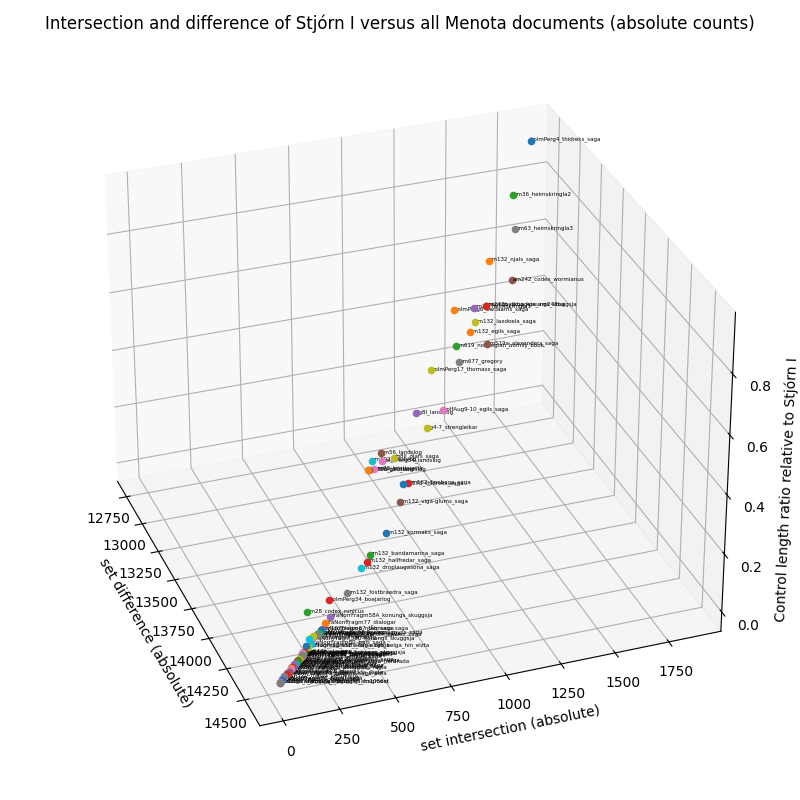

In [17]:
plot_intersection('stj1')

That seems a little useless at first sight: long texts have high intersect values and low difference values. But if we list these works by ratio of intersection/difference ratios and compare their length ratios, we can discern subtle differences:



In [18]:
def intersect_ratios(subject, sort='ratio'):
    intersection_data = []
    for k,v in menota.items():
        intersection_data.append((k, round(len(set(stjorn_tokens[subject]).intersection(set(v)))/len(set(stjorn_tokens[subject]).difference(set(v))), 2), len(v)))
    df = pd.DataFrame(intersection_data, columns=['work', 'ratio', 'length'])
    if sort == 'length':
        df = df.sort_values(by=['length'], ascending=False).reset_index(drop=True)    
    else:
        df = df.sort_values(by=['ratio'], ascending=False).reset_index(drop=True)
    df['length'] = df['length'].map('{:,}'.format)
    return df[:20]

In [19]:
intersect_ratios('stj1', sort='ratio')

,work,ratio,length
0,holmPerg4_thidreks_saga,0.15,"115,195"
1,am63_heimskringla3,0.14,"83,932"
2,am36_heimskringla2,0.13,"99,487"
3,am242_codex_wormianus,0.13,"62,856"
4,am132_njals_saga,0.12,"82,175"
5,am243balpha_konungs_skuggsja,0.12,"63,888"
6,am519a_alexanders_saga,0.12,"46,797"
7,konungs_skuggsja_am243ba,0.12,"63,888"
8,am132_egils_saga,0.11,"59,835"
9,am35_heimskringla1,0.11,"68,552"


The count of forms shared between _Alexanders saga_ in AM 519a and _Stjórn I_ in Unger's edition divided by the count of forms not shared between the two is higher than we would expect for its length if judged by the other long works. This may become clearer still if we sort these results by token count:

In [20]:
intersect_ratios('stj1', sort='length')

,work,ratio,length
0,holmPerg4_thidreks_saga,0.15,"115,195"
1,am36_heimskringla2,0.13,"99,487"
2,am63_heimskringla3,0.14,"83,932"
3,am132_njals_saga,0.12,"82,175"
4,holmPerg6_barlaams_saga,0.10,"76,411"
5,am35_heimskringla1,0.11,"68,552"
6,am243balpha_konungs_skuggsja,0.12,"63,888"
7,konungs_skuggsja_am243ba,0.12,"63,888"
8,am242_codex_wormianus,0.13,"62,856"
9,am132_laxdoela_saga,0.11,"61,851"


Not a lot of big shifts, but _Alexanders saga_ has now fallen out of the top 20, whereas by the ratio of intersection and difference it occupied sixth place. Codex Wormianus occupies ninth place by token count, so it too punches above its weight with its high intersection/difference ratio.

We can identify all such outliers by adding the length ratio into our intersection/difference ratio. However, the correlation between these ratios may not be linear, in the same way in which term-token ratios cannot be compared between works of different length, as longer works are by definition more repetitive in their choice of words/forms. Accordingly, _Þiðreks saga_ and _Heimskringla_ spoil a linear approach to this combined ratio. Or are they really more like _Stjórn I_ than other texts in the corpus?

In [21]:
def combined_ratios(subject, sort='ratio'):
    intersection_data = []
    for k,v in menota.items():
        intersection_data.append((k, (round((len(set(stjorn_tokens[subject]).intersection(set(v)))/len(set(stjorn_tokens[subject]).difference(set(v))) * (len(v) / len(stjorn_tokens[subject]))), 2)), len(v)))
    df = pd.DataFrame(intersection_data, columns=['work', 'ratio', 'length'])
    if sort == 'length':
        df = df.sort_values(by=['length'], ascending=False).reset_index(drop=True)    
    else:
        df = df.sort_values(by=['ratio'], ascending=False).reset_index(drop=True)
    df['length'] = df['length'].map('{:,}'.format)
    return df[:20]

In [22]:
combined_ratios('stj1')

,work,ratio,length
0,holmPerg4_thidreks_saga,0.14,"115,195"
1,am36_heimskringla2,0.11,"99,487"
2,am63_heimskringla3,0.09,"83,932"
3,am132_njals_saga,0.08,"82,175"
4,am242_codex_wormianus,0.07,"62,856"
5,holmPerg6_barlaams_saga,0.06,"76,411"
6,am243balpha_konungs_skuggsja,0.06,"63,888"
7,konungs_skuggsja_am243ba,0.06,"63,888"
8,am35_heimskringla1,0.06,"68,552"
9,am132_laxdoela_saga,0.05,"61,851"


_Alexanders saga_ actually does a lot worse in this ranking, where I was expecting it to score highly. I will need to rethink my methods.

Before we zoom in to identify which word forms stand out among these data, let's see how the other constituent parts of _Stjórn_ compare to the works in Menota:

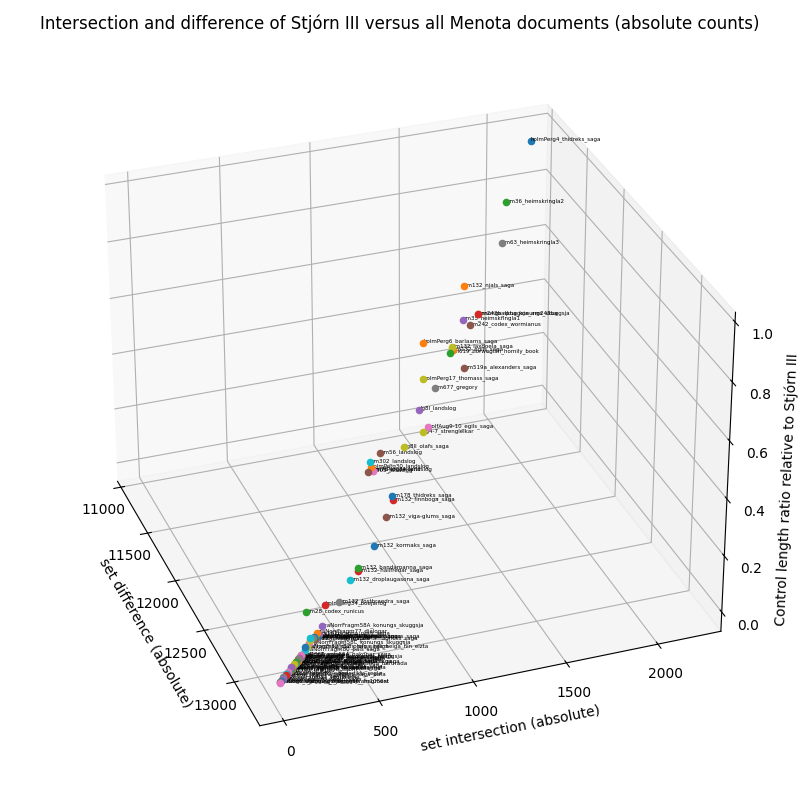

In [23]:
plot_intersection('stj3')

In [24]:
intersect_ratios('stj3', sort='ratio')

,work,ratio,length
0,holmPerg4_thidreks_saga,0.20,"115,195"
1,am63_heimskringla3,0.17,"83,932"
2,am36_heimskringla2,0.17,"99,487"
3,am243balpha_konungs_skuggsja,0.15,"63,888"
4,konungs_skuggsja_am243ba,0.15,"63,888"
5,am242_codex_wormianus,0.14,"62,856"
6,am519a_alexanders_saga,0.14,"46,797"
7,am132_njals_saga,0.14,"82,175"
8,am132_egils_saga,0.13,"59,835"
9,am35_heimskringla1,0.13,"68,552"


In [25]:
combined_ratios('stj3')

,work,ratio,length
0,holmPerg4_thidreks_saga,0.19,"115,195"
1,am36_heimskringla2,0.14,"99,487"
2,am63_heimskringla3,0.12,"83,932"
3,am132_njals_saga,0.09,"82,175"
4,konungs_skuggsja_am243ba,0.08,"63,888"
5,am243balpha_konungs_skuggsja,0.08,"63,888"
6,am35_heimskringla1,0.08,"68,552"
7,am242_codex_wormianus,0.07,"62,856"
8,am132_laxdoela_saga,0.06,"61,851"
9,holmPerg6_barlaams_saga,0.06,"76,411"


The fact that _Þiðreks saga_ and _Heimskringla_ continue to top the charts here even after attempting to correct for length suggests that yes, document length continues to spoil our results. In fact, _Alexanders saga_ ranks lower down after correcting for length, which is the opposite of the expected result. Clearly this metric could stand rethinking.

# Word Counts and Qualified Intersection

In the meantime, let's focus in on words that stand out. We can start by doing word frequency counts for each of the constituent parts of _Stjórn_ as well as for the Menota documents:

In [26]:
stjorn_counts = dict()
for i in ['stj1', 'stj2', 'stj3', 'stj4']:
    stjorn_counts[i] = Counter(stjorn_tokens[i])

menota_counts = dict()
for k,v in menota.items():
    menota_counts[k] = Counter(v)

This allows us to do things with relative frequency:

In [27]:
stjorn_counts['stj1'].most_common()[:20]

[('oc', 7849),
 ('sem', 3668),
 ('at', 3437),
 ('hann', 2838),
 ('er', 2141),
 ('af', 2106),
 ('i', 2009),
 ('sua', 1884),
 ('til', 1716),
 ('da', 1713),
 ('medr', 1442),
 ('dat', 1341),
 ('enn', 1260),
 ('fyrir', 1165),
 ('uar', 1096),
 ('dar', 1031),
 ('deir', 931),
 ('aa', 880),
 ('eigi', 817),
 ('hans', 809)]

But more usefully, we'll create a table with each form attested anywhere in _Stjórn_ to its own row, with columns giving the tally of that form in each of _Stjórn I--IV_ as well as each of the Menota documents:

In [28]:
stjorn_terms = set(stjorn_tokens['stj1'] + stjorn_tokens['stj2'] + stjorn_tokens['stj3'] + stjorn_tokens['stj4'])
works = list(stjorn_tokens.keys()) + list(menota.keys())
frequencies = dict()
for term in stjorn_terms:
    _frequencies = []
    for part in stjorn_tokens.keys():
        _frequencies.append(stjorn_counts[part][term] if not None else 0)
    for work in menota.keys():
        _frequencies.append(menota_counts[work][term] if not None else 0)
    frequencies[term] = _frequencies

df = pd.DataFrame.from_dict(frequencies, orient='index', columns=works)


In [29]:
df

,stj1,stj2,stj3,stj4,nraNorrFragm75_kross_saga,am132_egils_saga,am162btheta_njals_saga,nraNorrFragm64_barlaams_saga,nraNorrFragm81A_benedikts_regla,am1056IX_konungs_skuggsja_fragment,...,nraNorrFragm60B_stjorn,nraNorrFragm55A_hakonar_saga,skbA120_marys_complaint,nraNorrFragm59_rimbegla,nraNorrFragm65_floress_saga,nraNorrFragm52_olafs_saga_helga_hin_elzta,holmPerg6_barlaams_saga,nraNorrFragm68_brendanuss_saga,nraNorrFragm61_karlamagnuss_saga,nraNorrFragm58A_konungs_skuggsja
lægdr,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eda,4,103,9,0,0,6,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
uænuztu,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sefr,2,4,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
do,242,15,186,2,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yla,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
endrlifga,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rannsacan,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
buinn,3,3,14,0,0,24,0,0,0,0,...,0,0,0,0,0,0,19,0,2,0


The question now becomes how best to extract outliers from this matrix. For instance, we can produce a list of forms attested in only a handful of works outside of _Stjórn_. Perhaps we had best draw up individual results for each of the constituent parts of _Stjórn_.

The difficulty with this approach is that some eighty percent of terms used in _Stjórn I_ or _Stjórn III_ occur in five or fewer Menota documents. Thus to arrive at a meaningful result, we'll have to involve a minimum number of occurrences per document as well:

In [30]:
def outlier_terms(subject):
    results = []
    # Limit the dataframe to terms used (more than n times) in subject (experiment with n):
    rslt_df = df.query('{} > 4'.format(subject))
    control_df = rslt_df.drop(['stj1', 'stj2', 'stj3', 'stj4'], axis=1)
    control_df = control_df.transpose()
    # List terms used (more than n times) in more than n control documents (experiment with both n):
    for term, values in control_df.items():
        if (values > 4).sum() < 6:
            results.append(term)
    print(f"The number of returns is {len(results)}. That's out of {len(df.query('{} > 0'.format(subject)))} total terms used in {titles[subject]}, or {round(len(results)/len(df.query('{} > 0'.format(subject))) * 100, 2)} percent.")
    outfile = 'outliers_' + subject + '.txt'
    with open(outfile, 'w') as f:
        for i in results:
            f.write(i + '\n')

In [31]:
outlier_terms('stj1')

The number of returns is 2033. That's out of 14600 total terms used in Stjórn I, or 13.92 percent.


In [32]:
outlier_terms('stj3')

The number of returns is 1854. That's out of 13284 total terms used in Stjórn III, or 13.96 percent.


Once a balance has been found, it may be worth manually identifying terms for which synonyms are used elsewhere in the Menota corpus, to establish a lexical dialect.

The approach here used is really a primitive variant of TF-IDF, so see [the corresponding notebook](https://github.com/langeslag/on-corpus-tools/blob/main/stjorn/tf-idf.ipynb) before reading the next section.